In [1]:
# !pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import logging
import multiprocessing
from datetime import datetime, timedelta

from src import modules as f
%load_ext autoreload
%autoreload 2

In [3]:
# Download, load, extract, model...
interval = '1d'
stock_set = f.download_interval_process(interval, 1)
print(f'Stock set: \n{stock_set}\n')

Stock set: 
{'GOOGL', 'OKE', 'AMGN', 'KMI', 'JPM', 'UNH', 'WFC', 'AAPL', 'GOOG', 'AEP', 'PM', 'MA', 'NRG', 'LLY', 'IBM', 'SW', 'PG', 'DIS', 'MSI', 'CMCSA', 'NEM', 'ABT', 'FWONK', 'PGR', 'AXP', 'DASH', 'TDG', 'AJG', 'NTRA', 'COST', 'SPGI', 'GS', 'MDLZ', 'XEL', 'AVGO', 'CEG', 'SRE', 'DUK', 'PEG', 'EA', 'LNG', '^VIX', 'NVDA', 'VZ', 'WMB', 'EXE', 'NFLX', 'EXC', 'TMO', 'PEP', 'HD', 'D', 'EOG', 'RBA.TO', 'ISRG', 'ORCL', 'CRM', 'META', 'SO', 'CVX', 'NEE', 'JNJ', 'TMUS', 'ALL', 'ACN', 'APH', 'WMT', 'KO', 'MRK', 'CSCO', 'WSM', 'PSX', 'ATO', 'CRH', 'BRK-B', 'SLB', 'TSLA', 'KMB', 'AMZN', 'NTNX', 'MSFT', 'COP', 'MO', 'PLTR', 'XOM', 'CL', 'ABBV', 'V', 'BSX', 'BAC', 'T', 'LII'}



In [4]:
f.make_table_features_process(stock_set, interval, 8)

In [5]:
f.make_master_table(stock_set, interval)

Saved combined dataframe to: ./data_transformed/all_1d_model_df.pkl


In [7]:
f.xg_boost_model(interval='1d', grid_search_on=True)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__reg_alpha=0.0, classifier__reg_lambda=1.0, feature_selection__threshold=median;, score=0.352 total time=  16.6s
[CV 3/3] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__reg_alpha=0.0, classifier__reg_lambda=1.0, feature_selection__threshold=0.005;, score=0.364 total time=  20.1s
[CV 2/3] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__reg_alpha=0.5, classifier__reg_lambda=1.0, feature_selection__threshold=median;, score=0.351 total time=  18.4s
[CV 3/3] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__reg_alpha=0.5, classifier__reg_lambda=1.0, feature_selection__threshold=0.005;, score=0.364 total time=  18.9s
[CV 3/3] END classifier__learning_rate=0.1, clas

In [10]:
symbol = 'nvda'.upper()
interval = '1d'
f.model_prospect(symbol, interval, build=False)
df_val = f.model_validation(symbol, interval)
correctly_predicted = df_val.dir_pred_match.sum()
print(f'\nCorrectly Predicted: {correctly_predicted}')
entries_predicted = df_val.shape[0]
print(f'Entries Predicted: {entries_predicted}')
print(f'Percent Correct: {correctly_predicted / entries_predicted}')


Model Prediction 1d NVDA:
Predicted Next 1d Movement: DOWN

Model Prediction Probabilities:
no_change (0): 0.3345
up (1): 0.3038
down (2): 0.3617

Last Entry 1d NVDA Datetime Used for Prediction:
NOTE: It's in or contains the full 1d time interval.
EST: 2025-04-17 12:00:00 AM EDT-0400
PDT: 2025-04-16 09:00:00 PM PDT-0700

Correctly Predicted: 40
Entries Predicted: 100
Percent Correct: 0.4


In [ ]:
# !pip install pmdarima statsmodels prophet

In [21]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

stock_symbol = 'NVDA'.upper()
interval = '1d'
f.download(stock_symbol, interval)
stock_data = f.load_raw(stock_symbol, interval)
stock_data

,open,high,low,close,adj_close,volume
Date,,,,,,
1999-01-22 00:00:00-05:00,0.043750,0.048828,0.038802,0.041016,0.037612,2714688000
1999-01-25 00:00:00-05:00,0.044271,0.045833,0.041016,0.045313,0.041552,510480000
1999-01-26 00:00:00-05:00,0.045833,0.046745,0.041146,0.041797,0.038328,343200000
1999-01-27 00:00:00-05:00,0.041927,0.042969,0.039583,0.041667,0.038209,244368000
1999-01-28 00:00:00-05:00,0.041667,0.041927,0.041276,0.041536,0.038089,227520000
...,...,...,...,...,...,...
2025-04-11 00:00:00-04:00,108.500000,111.550003,107.480003,110.930000,110.930000,313417300
2025-04-14 00:00:00-04:00,114.110001,114.290001,109.070000,110.709999,110.709999,264705000
2025-04-15 00:00:00-04:00,110.970001,113.620003,110.500000,112.199997,112.199997,228966900


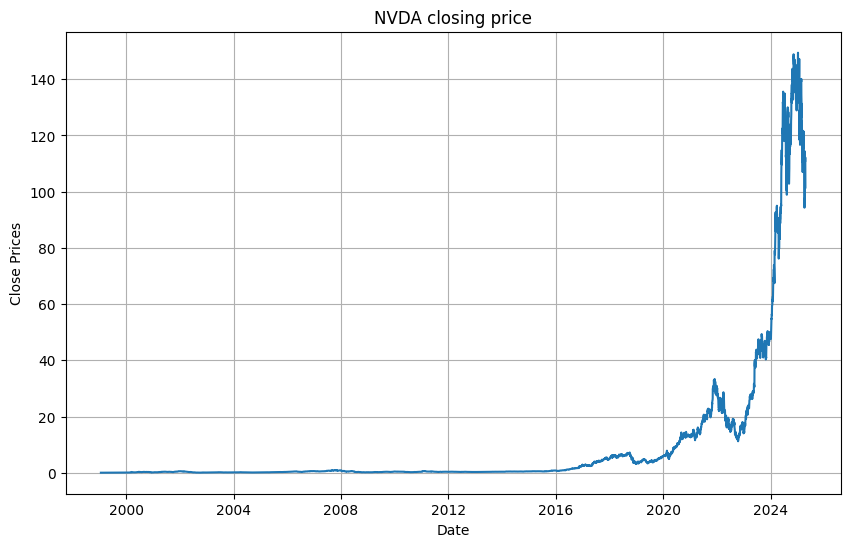

In [22]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['close'])
plt.title(f'{stock_symbol} closing price')
plt.show()

<Axes: ylabel='Density'>

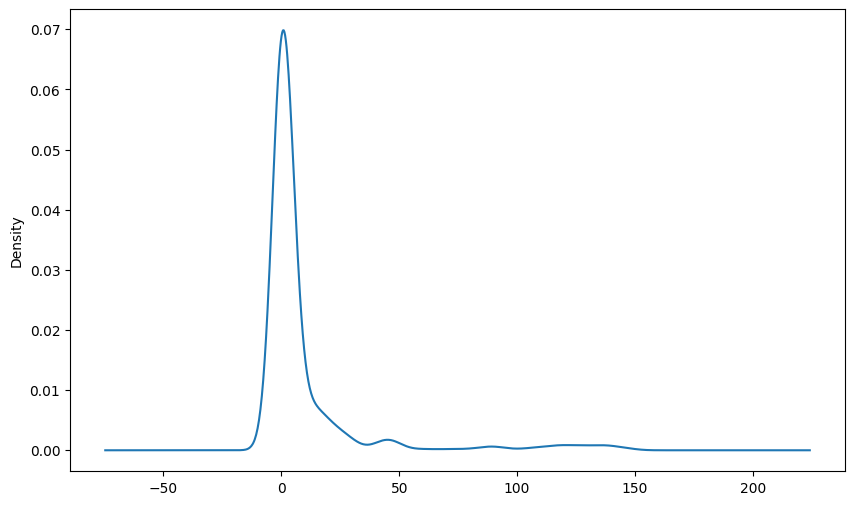

In [23]:
#Distribution of the dataset
df_close = stock_data['close']
df_close.plot(kind='kde')

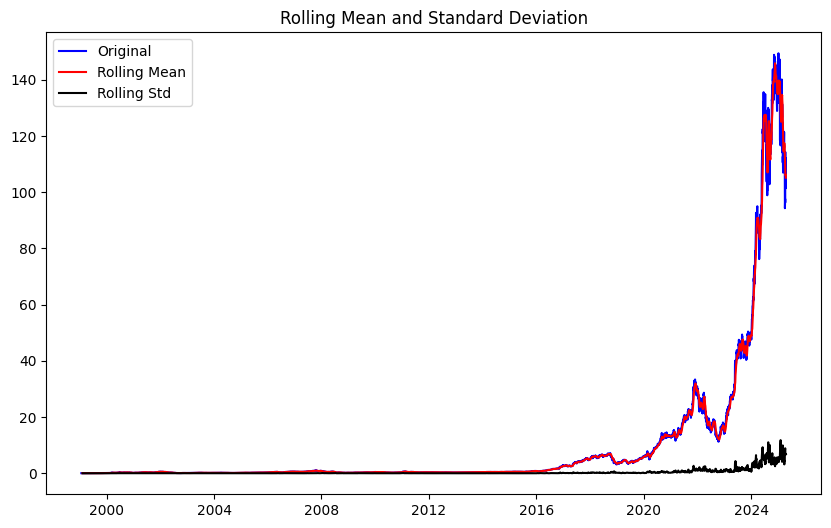

Results of dickey fuller test
Test Statistics                   0.854952
p-value                           0.992473
No. of lags used                 35.000000
Number of observations used    6565.000000
critical value (1%)              -3.431346
critical value (5%)              -2.861980
critical value (10%)             -2.567004
dtype: float64


In [24]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(10,6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 1000x600 with 0 Axes>

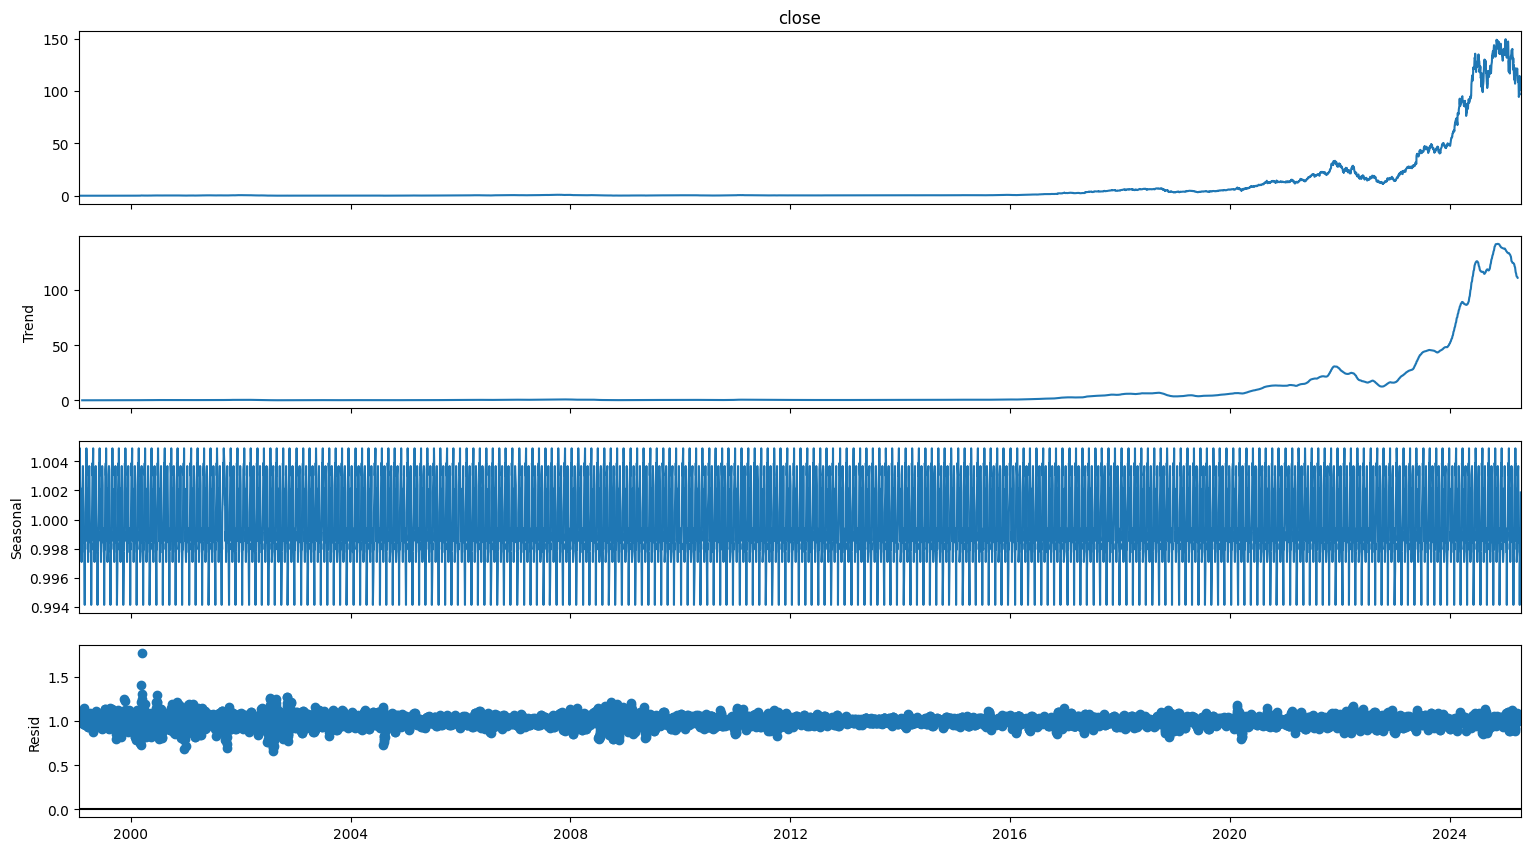

In [25]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

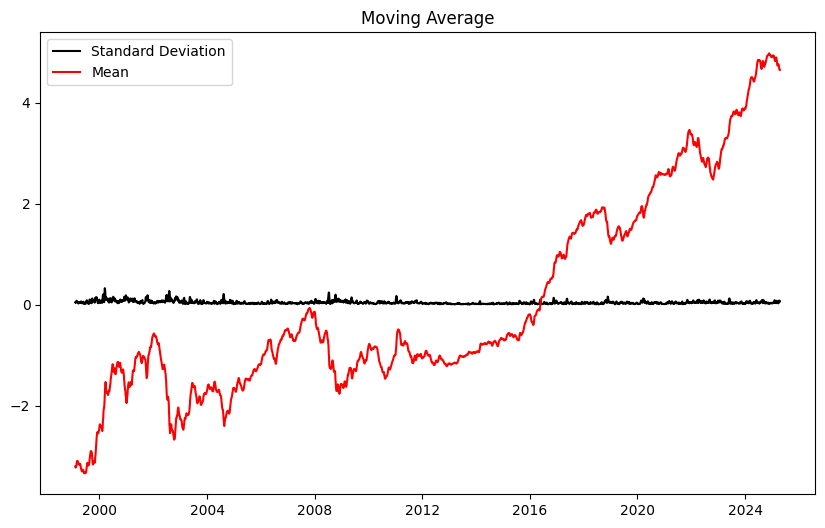

In [26]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

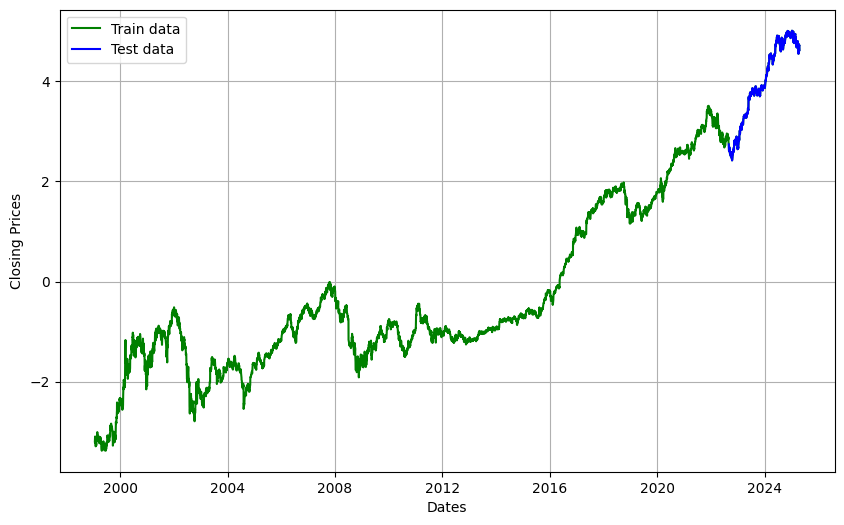

In [27]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21951.028, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21949.029, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21949.029, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21948.932, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21947.028, Time=0.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.510 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5937
Model:               SARIMAX(0, 1, 0)   Log Likelihood               10977.514
Date:                Sun, 20 Apr 2025   AIC                         -21951.028
Time:                        00:41:27   BIC                         -21937.651
Sample:                             0   HQIC                        -21946.380
                               - 5937                             

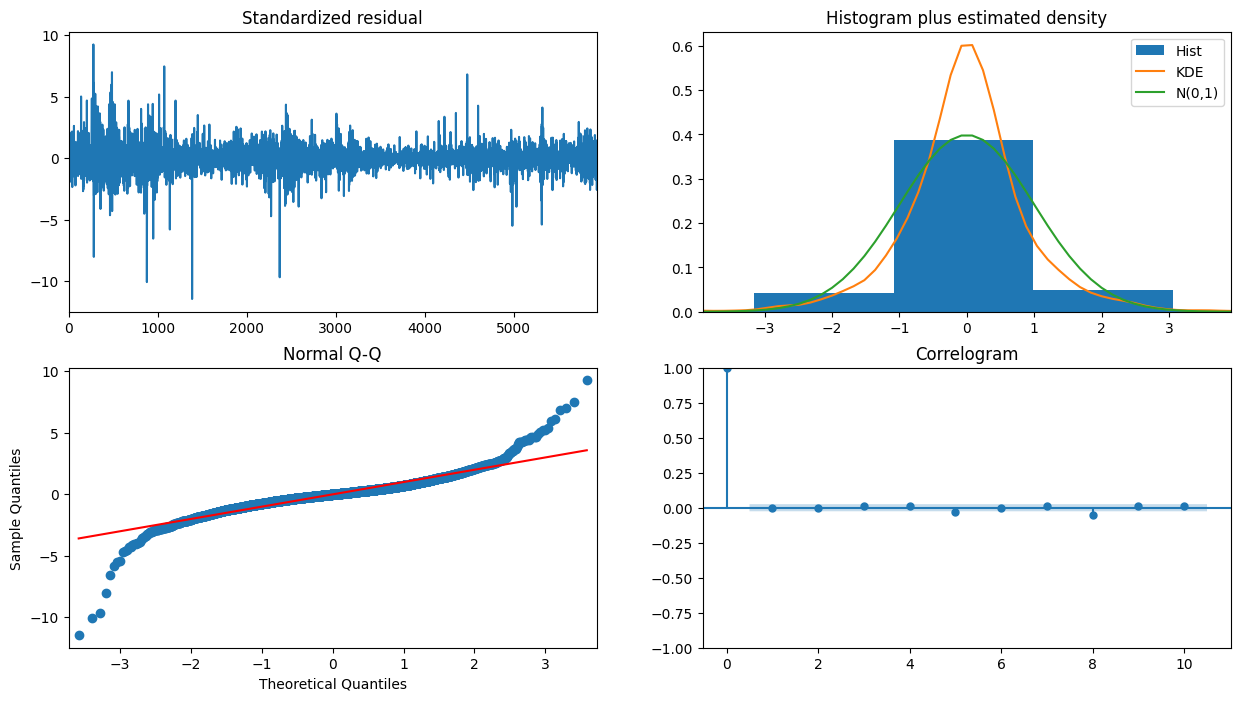

In [28]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [29]:
# Ensure training data is tz-naive and has BusinessDay frequency
train_data = train_data.copy()
train_data.index = train_data.index.tz_localize(None)
train_data = train_data.asfreq('B')

# If your data are in log scale and you wish to forecast on that scale, use trend='t' (drift)
model = ARIMA(train_data, order=(1,1,2), trend='t')
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 6154
Model:                 ARIMA(1, 1, 2)   Log Likelihood               10947.253
Date:                Sun, 20 Apr 2025   AIC                         -21884.506
Time:                        00:41:29   BIC                         -21850.883
Sample:                    01-27-1999   HQIC                        -21872.845
                         - 08-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0010      0.000      1.989      0.047    1.42e-05       0.002
ar.L1         -0.6602      1.724     -0.383      0.702      -4.040       2.719
ma.L1          0.6499      1.727      0.376      0.7

Training data last date: 2022-08-29 00:00:00
Test data first date: 2022-08-30 00:00:00
CI summary:
             lower       upper
count  321.000000  321.000000
mean     3.895990    5.653657
std      0.222333    0.396948
min      3.613428    4.695042
25%      3.712134    5.358639
50%      3.843377    5.706270
75%      4.037222    5.991301
max      4.546895    6.243794


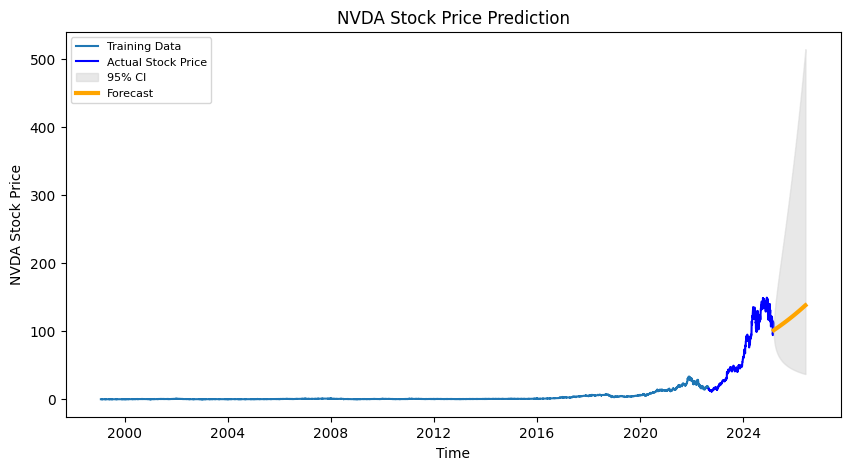

In [30]:
# Set this flag: True if your model and data are in log scale; False if in level scale.
log_data = True

# ----- Prepare Training Data -----
train_data = train_data.copy()
train_data.index = train_data.index.tz_localize(None)
# Force training data to have BusinessDay frequency.
train_data = train_data.asfreq('B')  # Now train_data.index has frequency, e.g. "<BusinessDay>"

# ----- Prepare Test Data -----
freq = train_data.index.freq  # should be <BusinessDay>
test_index = pd.date_range(
    start=train_data.index[-1] + pd.Timedelta(days=1),
    periods=len(test_data),
    freq=freq
)
test_data = test_data.copy()
test_data.index = test_index

print("Training data last date:", train_data.index[-1])
print("Test data first date:", test_data.index[0])
assert test_data.index[0] > train_data.index[-1], "Test data index does not extend training data!"

# ----- Update Model State -----
fitted.model.data.orig_endog.index = train_data.index
fitted.model.data.dates = train_data.index

fitted_updated = fitted.append(test_data, refit=False)

# ----- Forecast Simulation Using get_forecast -----
forecast_steps = 321
forecast_object = fitted_updated.get_forecast(steps=forecast_steps)
fc_series = forecast_object.predicted_mean
conf_int = forecast_object.conf_int(alpha=0.05)

# Rename the CI columns (if necessary)
conf_int.columns = ['lower', 'upper']

# For debugging, print a summary of the CI values.
print("CI summary:\n", conf_int.describe())

# If the model is built on log-scale data, convert forecasts and intervals back to price levels.
if log_data:
    fc_series = np.exp(fc_series)
    conf_int = np.exp(conf_int)
    last_actual_value = np.exp(test_data.iloc[-1])
else:
    last_actual_value = test_data.iloc[-1]

# Prepend the last observed test value so the forecast connects.
fc_series_full = pd.concat([pd.Series([last_actual_value], index=[test_data.index[-1]]), fc_series])
conf_int_full = pd.concat([
    pd.DataFrame({"lower": [last_actual_value], "upper": [last_actual_value]}, index=[test_data.index[-1]]),
    conf_int
])

# (Optional for debugging) – You could widen the CI band temporarily for visibility.
# For example, multiply the difference by 3:
# conf_int_full["upper"] = fc_series_full + 3*(conf_int_full["upper"] - fc_series_full)
# conf_int_full["lower"] = fc_series_full - 3*(fc_series_full - conf_int_full["lower"])

# ----- Plotting -----
plt.figure(figsize=(10, 5), dpi=100)
if log_data:
    plt.plot(np.exp(train_data), label='Training Data', zorder=1)
    plt.plot(np.exp(test_data), color='blue', label='Actual Stock Price', zorder=2)
else:
    plt.plot(train_data, label='Training Data', zorder=1)
    plt.plot(test_data, color='blue', label='Actual Stock Price', zorder=2)

# Fill the CI band.
plt.fill_between(conf_int_full.index,
                 conf_int_full["lower"],
                 conf_int_full["upper"],
                 color='lightgrey', alpha=0.5, label='95% CI', zorder=3)

# Plot the forecast as a bold orange line.
plt.plot(fc_series_full.index, fc_series_full,
         color='orange', linewidth=3, label='Forecast', zorder=4)

plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{stock_symbol} Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()
